In [0]:
import zipfile
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Dropout, Activation,Flatten
from tensorflow.keras.layers import Input, concatenate, Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
from keras import optimizers
from keras.utils import np_utils
%matplotlib inline

from google.colab import drive, files
drive.mount('/content/gdrive',force_remount = True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive


Using TensorFlow backend.


## Unzipping the file with the images

In [0]:
with zipfile.ZipFile('/content/gdrive/My Drive/Big Data/Projet/celeba-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/img/')

# Resize images

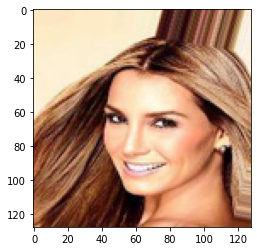

In [0]:
image = Image.open('/content/img/img_align_celeba/img_align_celeba/000001.jpg')
new_image = image.resize((128, 128))
plt.imshow(new_image)

# Preprocessing: devided the image into two : the mouth and the upper part of the face

In [0]:
attr = pd.read_csv('/content/img/list_landmarks_align_celeba.csv')
samp = pickle.load(open('/content/gdrive/My Drive/Big Data/Projet/Listes sample/Young.pkl', 'rb'))

In [0]:
attr = attr[['image_id', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y']]

In [0]:
#select images
coord = attr.loc[attr[attr['image_id'].isin(samp) == True].index]
coord = coord.set_index('image_id')
coord.head()

,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
image_id,,,,
000020.jpg,72,152,103,151
000040.jpg,73,152,103,152
000056.jpg,74,152,103,152
000064.jpg,71,151,106,152
000066.jpg,65,149,114,150


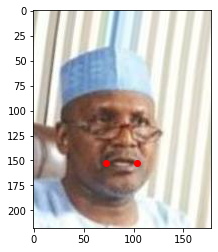

In [0]:
np.random.seed(1997)
aleatoire = np.random.randint(len(coord))
image = Image.open('/content/img/img_align_celeba/img_align_celeba/' + coord.index[aleatoire])
plt.imshow(image)
plt.scatter(coord['leftmouth_x'].iloc[0], coord['leftmouth_y'].iloc[aleatoire],
            c = 'r', marker = 'o')
plt.scatter(coord['rightmouth_x'].iloc[0], coord['rightmouth_y'].iloc[aleatoire],
            c = 'r', marker = 'o')

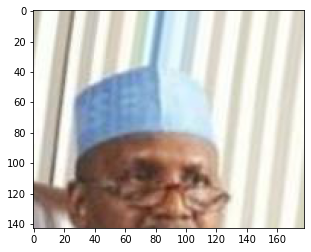

In [0]:
plt.imshow(image.crop((0, 0, 178, min(coord.leftmouth_y.loc[coord.index[aleatoire]],
                                      coord.rightmouth_y.loc[coord.index[aleatoire]])-10) ))

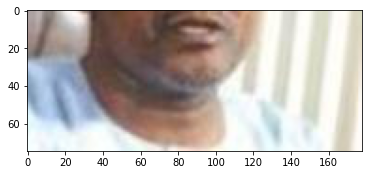

In [0]:
plt.imshow(image.crop((0, min(coord.leftmouth_y.loc[coord.index[aleatoire]],
                              coord.rightmouth_y.loc[coord.index[aleatoire]])-10, 178, 218))) 

# Création de la base de données

In [0]:
coord.head()

,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
image_id,,,,
000020.jpg,72,152,103,151
000040.jpg,73,152,103,152
000056.jpg,74,152,103,152
000064.jpg,71,151,106,152
000066.jpg,65,149,114,150


In [0]:
path = '/content/img/img_align_celeba/img_align_celeba/'
target = []
data_upper = np.zeros((len(samp), 64, 64, 3)) #dimension of the images
count = 0
for file in os.listdir(path):
  if file in samp :
    temp = file
    image = Image.open(path + file)
    
    separation = min(coord.leftmouth_y.loc[file],
                    coord.rightmouth_y.loc[file])-10
    image = image.crop((0, 0, 178, separation))
    image = image.resize((64, 64))
    image = np.array(image)
    data_upper[count] = image
    target.append(file)
    if count%1000 == 0 :
      print(count)
    count += 1
    


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [0]:
data_under = np.zeros((len(target), 64, 64, 3)) #dimension of the images
count = 0
for file in target :
    image = Image.open(path + file)
    separation = min(coord.leftmouth_y.loc[file],
                     coord.rightmouth_y.loc[file])-10
    image = image.crop((0, separation, 178, 218))
    image = image.resize((64, 64))
    data_under[count] = np.array(image)
    if count%1000 == 0 :
      print(count)
    count += 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [0]:
all_attributes = pd.read_csv('/content/img/list_attr_celeba.csv')
smiling = all_attributes[['image_id','Young']]
smiling = smiling.loc[smiling[smiling['image_id'].isin(target) == True].index]
smiling = smiling.set_index('image_id')
smiling = smiling.loc[target]
smiling.head()

,Young
image_id,
124526.jpg,-1
064612.jpg,-1
163447.jpg,1
025460.jpg,1
190788.jpg,1


# Creation of the train and test sets

In [0]:
target = np.array(smiling.Young)
target[target==-1] = 0

In [0]:
X_train_under, X_test_under, y_train, y_test = train_test_split(data_under, target, 
                                                                test_size = 0.2, random_state = 0)
X_train_upper, X_test_upper, y_train, y_test = train_test_split(data_upper, target, 
                                                                test_size = 0.2, random_state = 0)

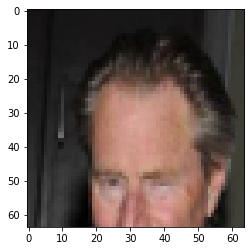

In [0]:
plt.imshow(X_train_upper[0].astype('uint8'))

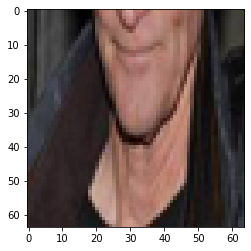

In [0]:
plt.imshow(X_train_under[0].astype('uint8'))

# Creation of the NNs

Here we are going to create two neural networks to process on one part the upper part of the picture and on the second part ther lower part of the picture. Both networks will then join for the last connected layer

In [0]:
in1 = Input(shape = (64, 64, 3,),name = 'under_input')
x1 = Conv2D(64, (3, 3), activation = 'relu')(in1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Conv2D(128, (3, 3), activation = 'relu')(x1)
x1 = MaxPooling2D(pool_size = (2, 2))(x1)
x1 = Dropout(0.4)(x1)
x1 = Conv2D(256, (3, 3), activation = 'relu')(x1)
x1 = MaxPooling2D(pool_size = (2, 2))(x1)
x1 = Dropout(0.4)(x1)
x1 = Conv2D(512, (3, 3), activation = 'relu')(x1)
x1 = MaxPooling2D(pool_size = (2, 2))(x1)
x1 = Flatten()(x1)
out1 = Dense(2048, activation = 'relu')(x1)

in2 = Input((64, 64, 3), name = 'upper_input')
x2 = Conv2D(64, (3, 3), activation = 'relu')(in2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = Conv2D(128, (3, 3), activation = 'relu')(x2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = Dropout(0.4)(x2)
x2 = Conv2D(256, (3, 3), activation = 'relu')(x2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = Dropout(0.4)(x2)
x2 = Conv2D(512, (3, 3), activation = 'relu')(x2)
x2 = MaxPooling2D(pool_size = (2, 2))(x2)
x2 = Flatten()(x2)
out2 = Dense(2048, activation = 'relu')(x2)


x = concatenate([out1, out2])
x = Dense(4096, activation = 'relu')(x)
x = Dropout(0.4)(x)
out = Dense(1, activation = 'sigmoid')(x)

model_smile = Model(inputs = [in1, in2], outputs = [out])

model_smile.compile(loss = 'binary_crossentropy', optimizer = 'Adam', 
                    metrics = ['accuracy'])

## callbacks to save the best model

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)

# Path where we will save our model
filepath = "/content/gdrive/My Drive/Big Data/models/Young.hdf5" 
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy',
                             verbose = 1, save_best_only = True,
                             mode = 'max')
callbacks = [checkpoint, reduce_lr]

In [0]:
model_smile.fit({'under_input': X_train_under, 'upper_input': X_train_upper},
                y_train, batch_size = 128, epochs = 40, 
                validation_data=({'under_input': X_test_under, 
                                  'upper_input': X_test_upper}, y_test), 
                                    callbacks = callbacks)

Epoch 1/40
125/125 [==============================] - ETA: 0s - loss: 15.5506 - accuracy: 0.5502
Epoch 00001: val_accuracy improved from -inf to 0.59925, saving model to /content/gdrive/My Drive/Big Data/models/Young.hdf5
125/125 [==============================] - 9s 69ms/step - loss: 15.5506 - accuracy: 0.5502 - val_loss: 0.6741 - val_accuracy: 0.5993 - lr: 0.0010
Epoch 2/40
125/125 [==============================] - ETA: 0s - loss: 0.6398 - accuracy: 0.6313
Epoch 00002: val_accuracy improved from 0.59925 to 0.60950, saving model to /content/gdrive/My Drive/Big Data/models/Young.hdf5
125/125 [==============================] - 8s 61ms/step - loss: 0.6398 - accuracy: 0.6313 - val_loss: 0.6417 - val_accuracy: 0.6095 - lr: 0.0010
Epoch 3/40
125/125 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.6513
Epoch 00003: val_accuracy improved from 0.60950 to 0.67450, saving model to /content/gdrive/My Drive/Big Data/models/Young.hdf5
125/125 [==============================

## Load the saved model

In [0]:
#modelLoaded = load_model("/content/gdrive/My Drive/Big Data/models/BestModelMale.hdf5")

In [0]:
pred = model_smile.predict({'under_input': X_test_under, 
                            'upper_input': X_test_upper}, verbose = 1) #get all predictions

125/125 [==============================] - 1s 6ms/step


## Test the predictions with the previous exemple when we put scatters on the mouth of the person on the picture

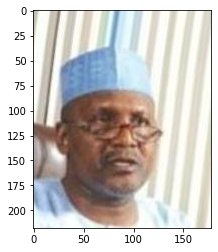

In [0]:
image = Image.open('/content/img/img_align_celeba/img_align_celeba/' + coord.index[aleatoire])
plt.imshow(image)

In [0]:
upper_image = np.zeros((1, 64, 64, 3))
temp = np.array(image.crop((0, 0, 178, min(coord.leftmouth_y.loc[coord.index[aleatoire]],
                                      coord.rightmouth_y.loc[coord.index[aleatoire]])-10) ).resize((64, 64)))
upper_image[0] = temp

In [0]:
under_image = np.zeros((1, 64, 64, 3))

temp = np.array(image.crop((0, min(coord.leftmouth_y.loc[coord.index[aleatoire]],
                              coord.rightmouth_y.loc[coord.index[aleatoire]])-10, 178, 218)).resize((64, 64)))

under_image[0] = temp

In [0]:
X_test_under.shape

(4000, 64, 64, 3)

1/1 [==============================] - 0s 1ms/step


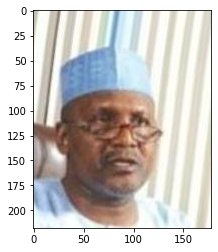

This person is :  old


In [0]:
pred_test = model_smile.predict({'under_input': under_image, 
                                 'upper_input': upper_image}, verbose=1) #get the prediction of this image


face = np.random.choice(len(y_test), 1)[0]
plt.imshow(image)
plt.show()
print_sex = lambda x: "young" if x >= 0.5 else "old"                        #Function that prints the predicted sex
print("This person is : ", print_sex(pred_test[0]))